## ENV SETUP

1. Install uv (or do it you're own way)
2. Run `uv sync`
3. Run `source .venv/bin/activate`

You're good to go.

# Instructions

The Task : Create the best CadQuery code generator model. 

1. Load the dataset (147K pairs of Images/CadQuery code).
2. Create a baseline model and evaluate it with the given metrics.
3. Enhance by any manner the baseline model and evaluate it again.
4. Explain you choices and possible bottlenecks. 
5. Show what enhancements you would have done if you had more time.

You can do *WHATEVER* you want, be creative, result is not what matters the most. 
Creating new model architectures, reusing ones you used in the past, fine-tuning, etc...

If you are GPU poor, there are solutions. Absolute value is not what matters, relative value between baseline and enhanced model is what matters.

In [ ]:
from datasets import load_dataset
ds = load_dataset("CADCODER/GenCAD-Code", num_proc=16, split=["train", "test"], cache_dir="/Volumes/BIG-DATA/HUGGINGFACE_CACHE")

## Evaluation Metrics

1. Valid Syntax Rate metric assess the validity of the code by executing and checking if error are returned.
2. Best IOU assess the similarity between the meshes generated by the code.

In [197]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

In [198]:
## Example usage of the metrics
sample_code = """
height = 60.0
width = 80.0
thickness = 10.0
diameter = 22.0

# make the base
result = (
    cq.Workplane("XY")
    .box(height, width, thickness)
)
"""

sample_code_2 = """
 height = 60.0
 width = 80.0
 thickness = 10.0
 diameter = 22.0
 padding = 12.0

 # make the base
 result = (
     cq.Workplane("XY")
     .box(height, width, thickness)
     .faces(">Z")
     .workplane()
     .hole(diameter)
     .faces(">Z")
     .workplane()
     .rect(height - padding, width - padding, forConstruction=True)
     .vertices()
     .cboreHole(2.4, 4.4, 2.1)
 )
"""
codes = {
    "sample_code": sample_code,
    "sample_code_2": sample_code_2,
}
vsr = evaluate_syntax_rate_simple(codes)
print("Valid Syntax Rate:", vsr)
iou = get_iou_best(sample_code, sample_code_2)
print("IOU:", iou)

Valid Syntax Rate: 1.0
IOU: 0.5834943417057687


## Have Fun

# Solution

In [199]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [200]:
torch.multiprocessing.set_start_method("spawn", force=True)

## Dataset Inspection

In [243]:
train_ds, test_ds = ds
train_ds = train_ds.select(range(5000))
test_ds_small = test_ds.select(range(1000))

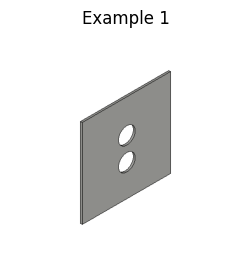

Code CadQuery 1:
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.75, -0.75), cq.Vector(3.749399456654644e-33, 1.0, -6.123233995736766e-17), cq.Vector(1.0, 0.0, 6.123233995736766e-17)))
loop0=wp_sketch0.moveTo(1.5, 0.0).lineTo(1.5, 1.5).lineTo(0.0, 1.5).lineTo(0.0, 0.0).close()
loop1=wp_sketch0.moveTo(0.7578947368421053, 0.5368421052631579).circle(0.14210526315789473)
loop2=wp_sketch0.moveTo(0.7578947368421053, 0.9315789473684211).circle(0.142105263...
--------------------------------------------------------------------------------


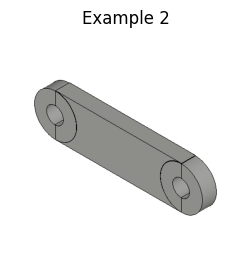

Code CadQuery 2:
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.5625, 0.0, -0.1875), cq.Vector(1.0, 6.123233995736766e-17, -6.123233995736766e-17), cq.Vector(6.123233995736766e-17, -1.0, 6.123233995736766e-17)))
loop0=wp_sketch0.moveTo(0.0, 0.375).threePointArc((-0.1875, 0.1875), (0.0, 0.0)).close()
solid0=wp_sketch0.add(loop0).extrude(0.125)
solid=solid0
# Generating a workplane for sketch 1
wp_sketch1 = cq.Workplane(cq.Plane(cq.Vector(0.5625, 0.0, -0...
--------------------------------------------------------------------------------


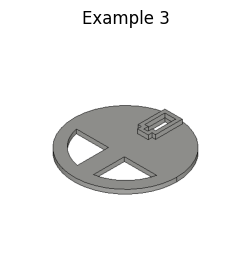

Code CadQuery 3:
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.578125, 0.0, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.5842105263157895, 0.0).circle(0.5842105263157895)
loop1=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.17511815627328084, -0.29900544272020846), (0.48684210526315785, -0.45032894736842105)).lineTo(0.48684210526315785, -0.09736842105263158).lineTo(0.12171052631578946, -0.09736842105263158).close(...
--------------------------------------------------------------------------------


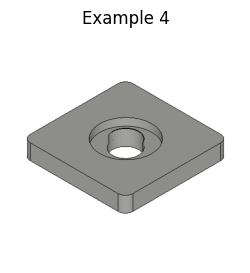

Code CadQuery 4:
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.75, -0.640625, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.03237240839517088, -0.07815390739430259), (0.1105263157894737, -0.1105263157894737)).lineTo(1.3894736842105264, -0.1105263157894737).threePointArc((1.4676275916048291, -0.07815390739430259), (1.5, 0.0)).lineTo(1.5, 1.2789473684210526).threePointArc((1.467627591604829...
--------------------------------------------------------------------------------


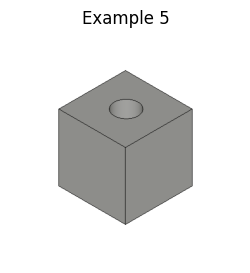

Code CadQuery 5:
import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.375, -0.375, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.75, 0.0).lineTo(0.75, 0.75).lineTo(0.0, 0.75).lineTo(0.0, 0.0).close()
loop1=wp_sketch0.moveTo(0.37894736842105264, 0.37894736842105264).circle(0.13421052631578947)
solid0=wp_sketch0.add(loop0).add(loop1).extrude(0.75)
solid=solid0
...
--------------------------------------------------------------------------------


In [244]:
for i in range(5):
    sample = test_ds_small[i]
    img = sample["image"]
    code = sample["cadquery"]

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Example {i+1}")
    plt.show()

    print(f"Code CadQuery {i+1}:\n{code[:500]}...\n{'-'*80}")


Available keys in a sample:
- image: <class 'PIL.PngImagePlugin.PngImageFile'>
- deepcad_id: <class 'str'>
- cadquery: <class 'str'>
- token_count: <class 'int'>
- prompt: <class 'str'>
- hundred_subset: <class 'bool'>

Number of training samples: 5000
Number of test samples: 7355

Image format: <class 'PIL.PngImagePlugin.PngImageFile'>
Image size (width, height): (448, 448)
Image mode: RGB

Most common image sizes:
- (448, 448): 100 occurrences

Image modes:
- RGB: 100 occurrences


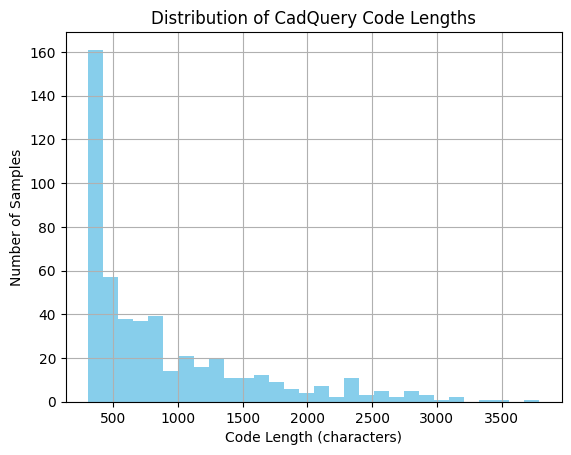

Average code length: 896.0
Max code length: 3791
Min code length: 308


In [245]:
sample = train_ds[0]
print("Available keys in a sample:")
for k in sample.keys():
    print(f"- {k}: {type(sample[k])}")

print(f"\nNumber of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

img = sample["image"]
print(f"\nImage format: {type(img)}")
print(f"Image size (width, height): {img.size}")
print(f"Image mode: {img.mode}")

image_shapes = [train_ds[i]["image"].size for i in range(100)]
image_modes = [train_ds[i]["image"].mode for i in range(100)]

print("\nMost common image sizes:")
for shape, count in Counter(image_shapes).items():
    print(f"- {shape}: {count} occurrences")

print("\nImage modes:")
for mode, count in Counter(image_modes).items():
    print(f"- {mode}: {count} occurrences")

code_lengths = [len(train_ds[i]["cadquery"]) for i in range(500)]
plt.hist(code_lengths, bins=30, color='skyblue')
plt.title("Distribution of CadQuery Code Lengths")
plt.xlabel("Code Length (characters)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print(f"Average code length: {np.mean(code_lengths):.1f}")
print(f"Max code length: {np.max(code_lengths)}")
print(f"Min code length: {np.min(code_lengths)}")


## Tokenizer & Dataset

In [246]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

SEQ_LEN = 128

In [247]:
class CADDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, seq_len=128):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.seq_len = seq_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        ex = self.dataset[idx]
        img = ex["image"].resize((224, 224))
        img = np.array(img) / 255.0
        if img.shape[-1] == 4:
            img = img[..., :3]
        img_tensor = torch.tensor(img).permute(2, 0, 1).float()

        tokens = self.tokenizer(
            ex["cadquery"],
            padding="max_length",
            truncation=True,
            max_length=self.seq_len
        )["input_ids"]
        token_tensor = torch.tensor(tokens, dtype=torch.long)

        return img_tensor, token_tensor

## Model & Training

In [248]:
class CADModel(nn.Module):
    def __init__(self, vocab_size, seq_len):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Identity()
        self.linear = nn.Linear(1280, 256)
        self.lstm = nn.LSTM(256, 256, batch_first=True)
        self.out = nn.Linear(256, vocab_size)
        self.seq_len = seq_len

    def forward(self, x):
        b = x.size(0)
        x = self.cnn(x)
        x = self.linear(x)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, _ = self.lstm(x)
        x = self.out(x)
        return x

In [249]:
train_dataset = CADDataset(test_ds_small, tokenizer, SEQ_LEN)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CADModel(vocab_size=tokenizer.vocab_size, seq_len=SEQ_LEN).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 5
log_interval = 10 

for epoch in range(EPOCHS):
    print(f"\n----------------------------- Epoch {epoch + 1}/{EPOCHS} -----------------------------")
    model.train()
    total_loss = 0.0

    for i, (imgs, tokens) in enumerate(train_loader):
       # print(f"Start batch {i + 1}/{len(train_loader)}")
        imgs, tokens = imgs.to(device), tokens.to(device)
        optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits.view(-1, logits.size(-1)), tokens.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print every 10 batches
        if (i + 1) % 10 == 0:
            print(f"[Batch {i + 1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch + 1} done. Avg loss: {avg_loss:.4f}")


----------------------------- Epoch 1/5 -----------------------------
[Batch 10/32] Loss: 3.9418
[Batch 20/32] Loss: 4.0933
[Batch 30/32] Loss: 3.8661
✅ Epoch 1 done. Avg loss: 3.9119

----------------------------- Epoch 2/5 -----------------------------
[Batch 10/32] Loss: 3.8750
[Batch 20/32] Loss: 3.8596
[Batch 30/32] Loss: 3.8101
✅ Epoch 2 done. Avg loss: 3.8340

----------------------------- Epoch 3/5 -----------------------------
[Batch 10/32] Loss: 3.8035
[Batch 20/32] Loss: 3.7848


## Metrics validations

In [261]:
import re
from PIL import Image

def generate_code(model, image, tokenizer, device="cpu"):
    """
    Generate CadQuery code from an input image using greedy decoding (argmax).
    """
    model.eval()

    # Preprocess image
    if isinstance(image, Image.Image):
        image = image.resize((224, 224))
        img = np.array(image) / 255.0
        if img.shape[-1] == 4:
            img = img[..., :3]
        image_tensor = torch.tensor(img).permute(2, 0, 1).float().unsqueeze(0).to(device)
    elif isinstance(image, torch.Tensor):
        image_tensor = image.unsqueeze(0).to(device)
    else:
        raise ValueError("Image must be a PIL Image or a torch.Tensor.")

    with torch.no_grad():
        logits = model(image_tensor)  # shape: [1, seq_len, vocab_size]
        token_ids = torch.argmax(logits, dim=-1).squeeze(0).tolist()
        decoded = tokenizer.decode(token_ids, skip_special_tokens=True)

    # Clean decoded text
    decoded = re.sub(r'[^\x00-\x7F]+', '', decoded)
    decoded = re.sub(r'[^\w\s\.\-\(\)\[\]\{\},:;=#\"\']+', '', decoded)
    return decoded.strip()


In [262]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

N = 5
codes = {}
ious = []

for i in range(N):
    sample = test_ds_small[i]
    img = sample["image"]
    gt_code = sample["cadquery"]

    pred_code = generate_code(model, img, tokenizer, device=device)
    if "import cadquery" not in pred_code:
        pred_code = "import cadquery as cq\n" + pred_code

    codes[f"gen_{i}"] = pred_code

    try:
        iou = get_iou_best(gt_code, pred_code)
        ious.append(iou)
    except Exception as e:
        print(f"IOU failed for sample {i}: {e}")
        ious.append(0.0)

    print(f"\n--- Sample {i+1} ---")
    print("Predicted Code:\n", pred_code[:300])
    print("\nGround Truth Code:\n", gt_code[:300])
    print(f"IOU: {ious[-1]:.4f}")
    print("-" * 80)

vsr = evaluate_syntax_rate_simple(codes)
mean_iou = sum(ious) / len(ious)

print(f"\nValid Syntax Rate (VSR): {vsr:.2%}")
print(f"Mean IOU: {mean_iou:.4f}")


IOU failed for sample 0: Error executing script unknown: invalid syntax (<string>, line 2)

--- Sample 1 ---
Predicted Code:
 import cadquery as cq
................................................................................................................................

Ground Truth Code:
 import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.75, -0.75), cq.Vector(3.749399456654644e-33, 1.0, -6.123233995736766e-17), cq.Vector(1.0, 0.0, 6.123233995736766e-17)))
loop0=wp_sketch0.moveTo(1.5, 0.0).lineTo(1.5, 1.5).lineTo(0.0, 1.5)
IOU: 0.0000
--------------------------------------------------------------------------------
IOU failed for sample 1: Error executing script unknown: invalid syntax (<string>, line 2)

--- Sample 2 ---
Predicted Code:
 import cadquery as cq
................................................................................................................................

Ground Truth Code:
 import cad

## Results review

- The model was trained for only 5 epochs on a reduced dataset of 1000 samples due to a poor CPU.
- The predicted code has a very low Valid Syntax Rate (VSR ≈ 0%) — likely due to insufficient training and limited sequence modeling capabilities.
- IOU score is also 0.0, indicating generated geometry is not aligning with expected shapes.

(These values are expected from a minimal training loop and a basic encoder-decoder design.)



## Identified Bottlenecks
- Training Speed: EfficientNet on CPU (or limited GPU) makes training extremely slow.
- Model Design: The LSTM decoder struggles to model long, structured code sequences.
- Tokenizer: CodeGen tokenizer isn't optimal for character-level code structure.
- Inference: Greedy decoding often yields repetitive or malformed outputs.

## Potential Improvements
- Replace the LSTM decoder with a Transformer-based decoder (e.g. GPT-style).
- Fine-tune or use a more suitable tokenizer (GPT-tokenizer trained on CAD).
- Introduce Beam Search with syntax constraints at inference.
- Train on the full 147K dataset for 10+ epochs with mixed precision and GPU support.